# 전이학습
- cifar10

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import seaborn as sns

## 데이터 준비

In [2]:
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train.shape, X_test.shape

170498071/170498071 [==============================] - 34s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True)

In [4]:
print(X_train.shape, X_val.shape)
print(X_test.shape)

(35000, 32, 32, 3) (15000, 32, 32, 3)
(10000, 32, 32, 3)


## 정규화

In [5]:
X_train = X_train.astype('float32')/255
X_val = X_val.astype('float32')/255
X_test = X_test.astype('float32')/255

In [20]:
from tensorflow.keras.utils import to_categorical

y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

## 모델


In [10]:
from tensorflow.keras.applications import VGG16

base = VGG16(weights='imagenet',
      input_shape=(32,32,3),
      include_top = False #top: flatten부터 끝까지 - 우린 필터 학습까지만 받을 거
      )

base.trainable=False #더 이상 학습 x

base.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

imagenet: ouput 분류가 1000개 

전체를 받으면 안되고 필터 학습시키는 부분까지만 받음

prediction(Dense)의 (, 1000) : ouput이 1000개라는 뜻



In [17]:
model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# 이걸로 전이학습 끝

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 14,748,170
Trainable params: 14,748,170
Non-trainable params: 0
_________________________________________________________________


## 학습

In [21]:
EPOCHS=30
BATCH_SIZE=64

log = model.fit(X_train, y_train_oh, 
                epochs = EPOCHS, 
                batch_size=BATCH_SIZE,
                validation_data = (X_val, y_val_oh),
                verbose=1)
#callback해도 됨

Epoch 1/30
547/547 [==============================] - 35s 46ms/step - loss: 2.1202 - acc: 0.1708 - val_loss: 1.8235 - val_acc: 0.2430
Epoch 2/30
547/547 [==============================] - 26s 47ms/step - loss: 1.8168 - acc: 0.2473 - val_loss: 1.6773 - val_acc: 0.2955
Epoch 3/30
547/547 [==============================] - 23s 43ms/step - loss: 1.6664 - acc: 0.3178 - val_loss: 1.4673 - val_acc: 0.4006
Epoch 4/30
547/547 [==============================] - 23s 42ms/step - loss: 1.5229 - acc: 0.3809 - val_loss: 1.3843 - val_acc: 0.4465
Epoch 5/30
547/547 [==============================] - 23s 43ms/step - loss: 1.4167 - acc: 0.4375 - val_loss: 1.2618 - val_acc: 0.5273
Epoch 6/30
547/547 [==============================] - 23s 42ms/step - loss: 1.3033 - acc: 0.4950 - val_loss: 1.1716 - val_acc: 0.5603
Epoch 7/30
547/547 [==============================] - 23s 43ms/step - loss: 1.2325 - acc: 0.5403 - val_loss: 1.1234 - val_acc: 0.5846
Epoch 8/30
547/547 [==============================] - 23s 43ms

In [22]:
# 학습 곡선
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],label = 'Val Accuracy')

    plt.legend()
    plt.show()

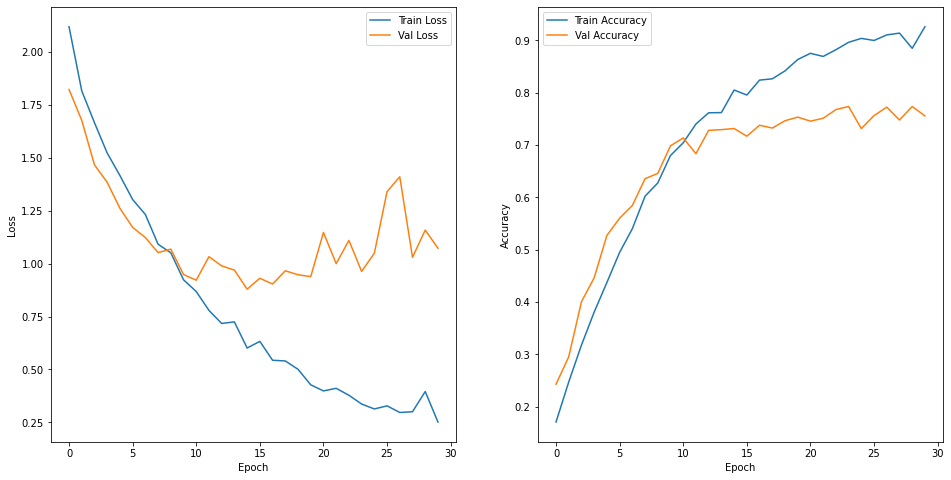

In [23]:
plot_history(log)

In [25]:
model.evaluate(X_test, y_test_oh)

313/313 [==============================] - 4s 11ms/step - loss: 1.0882 - acc: 0.7547


[1.088218092918396, 0.7547000050544739]

In [26]:
model.evaluate(X_train, y_train_oh)

1094/1094 [==============================] - 11s 10ms/step - loss: 0.2314 - acc: 0.9277


[0.23141510784626007, 0.9277142882347107]